In [0]:
# !wget https://huseinhouse-storage.s3-ap-southeast-1.amazonaws.com/reinforcement-learning/train_8M.csv
# !wget https://huseinhouse-storage.s3-ap-southeast-1.amazonaws.com/reinforcement-learning/transactions.csv
# !wget https://huseinhouse-storage.s3-ap-southeast-1.amazonaws.com/reinforcement-learning/holidays_events.csv
# !wget https://huseinhouse-storage.s3-ap-southeast-1.amazonaws.com/reinforcement-learning/items.csv
# !wget https://huseinhouse-storage.s3-ap-southeast-1.amazonaws.com/reinforcement-learning/oil.csv
# !wget https://huseinhouse-storage.s3-ap-southeast-1.amazonaws.com/reinforcement-learning/stores.csv
# !wget https://huseinhouse-storage.s3-ap-southeast-1.amazonaws.com/reinforcement-learning/recmetrics.zip
# !unzip recmetrics.zip

In [1]:
!ls

holidays_events.csv  __MACOSX  recmetrics      sample_data  train_8M.csv
items.csv	     oil.csv   recmetrics.zip  stores.csv   transactions.csv


In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from datetime import datetime, timedelta
import tensorflow as tf
import random
sns.set()

In [0]:
items = pd.read_csv("items.csv")
holiday_events = pd.read_csv("holidays_events.csv")
stores = pd.read_csv("stores.csv")
oil = pd.read_csv("oil.csv")
transactions = pd.read_csv("transactions.csv",parse_dates=['date'])
train = pd.read_csv("train_8M.csv", nrows = 500000, parse_dates=['date'])

In [4]:
from tensorflow.python.client import device_lib

device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 14532048091421936632, name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 16366765605937220764
 physical_device_desc: "device: XLA_CPU device", name: "/device:XLA_GPU:0"
 device_type: "XLA_GPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 5411859217718152837
 physical_device_desc: "device: XLA_GPU device", name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 14596482663
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 9944202638226918731
 physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"]

In [0]:
stores = train['store_nbr'].values
items = train['item_nbr'].values
reward = train['unit_sales'].values

In [6]:
encoded = LabelEncoder().fit_transform(items)
items_unique = np.unique(items)
items_unique

array([  96995,  103501,  103520, ..., 1114567, 1114749, 1118683])

In [0]:
from sklearn.model_selection import train_test_split

train_stores, test_stores, train, test = train_test_split(stores, 
                                                          train, test_size = 0.25, shuffle = False)

In [0]:
from collections import deque
import random

LEARNING_RATE = 1e-5
LAYER_SIZE = 256
OUTPUT_SIZE = np.unique(items).shape[0]
STATE_SIZE = np.unique(stores).shape[0]

class Model:
  def __init__(self):
    self.X = tf.placeholder(tf.int32, [None])
    self.Y = tf.placeholder(tf.float32, [None, OUTPUT_SIZE])

    embeddings = tf.Variable(tf.random_uniform([STATE_SIZE, LAYER_SIZE], -1, 1))
    embedded = tf.nn.embedding_lookup(embeddings, self.X)
    feed_forward = tf.layers.dense(embedded, LAYER_SIZE, activation = tf.nn.tanh)
    self.logits = tf.layers.dense(feed_forward, OUTPUT_SIZE)
    self.cost = tf.reduce_sum(tf.square(self.Y - self.logits))
    self.optimizer = tf.train.GradientDescentOptimizer(LEARNING_RATE).minimize(
        self.cost
    )
    
class Agent:

  EPSILON = 0.5
  DECAY_RATE = 0.005
  MIN_EPSILON = 0.1
  GAMMA = 0.95
  MEMORIES = deque()
  COPY = 200 #when reach 200 the constant in second network will be copied into first network
  T_COPY = 0
  MEMORY_SIZE = 300

  def __init__(self):
    tf.reset_default_graph()
    self.model = Model()
    self.model_negative = Model()
    self.sess = tf.InteractiveSession()
    self.sess.run(tf.global_variables_initializer())
    self.trainable = tf.trainable_variables()
    
  def _assign(self):
    for i in range(len(self.trainable)//2):
      assign_op = self.trainable[i+len(self.trainable)//2].assign(self.trainable[i])
      self.sess.run(assign_op)
      
  def _memorize(self, state, action, reward, new_state, done):
    self.MEMORIES.append((state, action, reward, new_state, done))
    if len(self.MEMORIES) > self.MEMORY_SIZE:
      self.MEMORIES.popleft()
      
  def _select_action(self, state):
    if np.random.rand() < self.EPSILON:
      action = np.random.randint(OUTPUT_SIZE, size = (len(state)))
    else:
      action = np.argmax(self.predict(state), axis = 1)
    return action
  
  def _construct_memories(self, replay):
    states = np.array([a[0] for a in replay])
    new_states = np.array([a[3] for a in replay])
    Q = self.predict(states)
    Q_new = self.predict(new_states)
    Q_new_negative = self.sess.run(self.model_negative.logits, 
                                   feed_dict={self.model_negative.X:new_states})
    replay_size = len(replay)
    X = np.empty((replay_size))
    Y = np.empty((replay_size, OUTPUT_SIZE))
    for i in range(replay_size):
      state_r, action_r, reward_r, new_state_r, done_r = replay[i]
      target = Q[i]
      target[action_r] = reward_r
      if not done_r:
          target[action_r] += self.GAMMA * Q_new_negative[i, np.argmax(Q_new[i])]
      X[i] = state_r
      Y[i] = target
    return X, Y
  
  def predict(self, inputs):
    return self.sess.run(self.model.logits, feed_dict={self.model.X:inputs})

In [10]:
agent = Agent()

W0726 08:17:24.391436 140704478992256 deprecation.py:323] From <ipython-input-9-ca27c2510511>:16: dense (from tensorflow.python.layers.core) is deprecated and will be removed in a future version.
Instructions for updating:
Use keras.layers.dense instead.
W0726 08:17:24.397062 140704478992256 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [0]:
train_pivoted = train.pivot_table(index='store_nbr', columns='item_nbr', values='unit_sales').fillna(0)

In [12]:
from tqdm import tqdm
epoch = 5
batch_size = 128

for e in range(epoch):
  pbar = tqdm(
      range(0, len(train_stores) - 1, batch_size), desc = 'train minibatch loop'
    )
  loss = []
  for i in pbar:
    index = min(i + batch_size, len(train_stores) - 1)
    if (agent.T_COPY + 1) % agent.COPY == 0:
      agent._assign()
    state = train_stores[i: index]
    action = agent._select_action(state)
    next_state = train_stores[i + 1: index + 1]
    for no, a in enumerate(action):
      if a >= train_pivoted.shape[1]:
        r = 0
      else:
        r = train_pivoted.loc[train_stores[i + no]].iloc[a]
      agent._memorize(state[no], a, r, next_state[no], r < 1)
    
    replay = random.sample(agent.MEMORIES, min(len(agent.MEMORIES), batch_size))
    X, Y = agent._construct_memories(replay)
    cost, _ = agent.sess.run([agent.model.cost, agent.model.optimizer], 
                               feed_dict={agent.model.X: X, agent.model.Y:Y}) 
    agent.T_COPY += 1
    agent.EPSILON = agent.MIN_EPSILON + (1.0 - agent.MIN_EPSILON) * np.exp(-agent.DECAY_RATE * i)
      
    pbar.set_postfix(cost = cost)
    loss.append(cost)
  print('epoch: %d, average lost: %f'%(e + 1, np.mean(loss)))

train minibatch loop:   0%|          | 4/2930 [00:00<01:19, 36.99it/s, cost=9.57e+5]

epoch: 1, average lost: 144592.781250


train minibatch loop:   0%|          | 4/2930 [00:00<01:27, 33.31it/s, cost=1.78e+6]

epoch: 2, average lost: 566448.125000


train minibatch loop:   0%|          | 4/2930 [00:00<01:24, 34.80it/s, cost=2.61e+4]

epoch: 3, average lost: 920085.812500


train minibatch loop:   0%|          | 4/2930 [00:00<01:22, 35.27it/s, cost=4.79e+6]

epoch: 4, average lost: 1080713.375000


train minibatch loop: 100%|██████████| 2930/2930 [01:24<00:00, 34.73it/s, cost=3.21e+6]

epoch: 5, average lost: 1099011.875000


In [14]:
agent.predict([1])

array([[34.37177  , 39.436737 , 74.57531  , ..., 84.20102  ,  0.2100472,
         0.5957482]], dtype=float32)

In [15]:
agent.predict([1]).shape

(1, 1607)

In [16]:
agent.predict([1, 2])

array([[34.37177   , 39.436737  , 74.57531   , ..., 84.20102   ,
         0.2100472 ,  0.5957482 ],
       [37.072964  , 40.948723  , 78.47587   , ..., 89.15367   ,
         0.5769611 ,  0.79328245]], dtype=float32)

In [17]:
test_cp = test.copy().groupby('store_nbr')['item_nbr'].agg({'actual': (lambda x: list(set(x)))})

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """Entry point for launching an IPython kernel.


In [0]:
def get_users_predictions(user_id, n):
  p = agent.predict([user_id])[0]
  p = p.argsort()[-n:][::-1]
  return [items_unique[i] for i in p]

In [20]:
recs = []
for user in test_cp.index:
    cf_predictions = get_users_predictions(user + 1, 30)
    recs.append(cf_predictions)
        
test_cp['cf_predictions'] = recs
test_cp.head()

,actual,cf_predictions
store_nbr,,
1,"[174081, 1058820, 862213, 819206, 460804, 8192...","[868529, 522941, 364606, 323921, 870544, 31517..."
2,"[174081, 460804, 862213, 819206, 1058820, 8192...","[868529, 522941, 364606, 323921, 870544, 31517..."
3,"[174081, 460804, 862213, 819206, 1058820, 8192...","[868529, 522941, 364606, 323921, 870544, 31517..."
4,"[174081, 460804, 862213, 819206, 1058820, 8192...","[868529, 522941, 364606, 323921, 870544, 31517..."
5,"[174081, 460804, 862213, 819206, 1058820, 8192...","[868529, 522941, 364606, 323921, 315179, 95943..."


In [21]:
popularity_recs = train.item_nbr.value_counts().head(30).index.tolist()

recs = []
for user in test_cp.index:
    pop_predictions = popularity_recs
    recs.append(pop_predictions)
        
test_cp['pop_predictions'] = recs
test_cp.head()

,actual,cf_predictions,pop_predictions
store_nbr,,,
1,"[174081, 1058820, 862213, 819206, 460804, 8192...","[868529, 522941, 364606, 323921, 870544, 31517...","[222879, 314384, 559870, 564533, 502331, 27352..."
2,"[174081, 460804, 862213, 819206, 1058820, 8192...","[868529, 522941, 364606, 323921, 870544, 31517...","[222879, 314384, 559870, 564533, 502331, 27352..."
3,"[174081, 460804, 862213, 819206, 1058820, 8192...","[868529, 522941, 364606, 323921, 870544, 31517...","[222879, 314384, 559870, 564533, 502331, 27352..."
4,"[174081, 460804, 862213, 819206, 1058820, 8192...","[868529, 522941, 364606, 323921, 870544, 31517...","[222879, 314384, 559870, 564533, 502331, 27352..."
5,"[174081, 460804, 862213, 819206, 1058820, 8192...","[868529, 522941, 364606, 323921, 315179, 95943...","[222879, 314384, 559870, 564533, 502331, 27352..."


In [22]:
recs = []
for user in test_cp.index:
    random_predictions = train.item_nbr.sample(30).values.tolist()
    recs.append(random_predictions)
        
test_cp['random_predictions'] = recs
test_cp.head()

,actual,cf_predictions,pop_predictions,random_predictions
store_nbr,,,,
1,"[174081, 1058820, 862213, 819206, 460804, 8192...","[868529, 522941, 364606, 323921, 870544, 31517...","[222879, 314384, 559870, 564533, 502331, 27352...","[413987, 352513, 363049, 1038952, 507870, 1109..."
2,"[174081, 460804, 862213, 819206, 1058820, 8192...","[868529, 522941, 364606, 323921, 870544, 31517...","[222879, 314384, 559870, 564533, 502331, 27352...","[627263, 946671, 268443, 269029, 470624, 87751..."
3,"[174081, 460804, 862213, 819206, 1058820, 8192...","[868529, 522941, 364606, 323921, 870544, 31517...","[222879, 314384, 559870, 564533, 502331, 27352...","[1105212, 802831, 265279, 329071, 857331, 4568..."
4,"[174081, 460804, 862213, 819206, 1058820, 8192...","[868529, 522941, 364606, 323921, 870544, 31517...","[222879, 314384, 559870, 564533, 502331, 27352...","[638308, 564287, 839367, 116017, 1088002, 4680..."
5,"[174081, 460804, 862213, 819206, 1058820, 8192...","[868529, 522941, 364606, 323921, 315179, 95943...","[222879, 314384, 559870, 564533, 502331, 27352...","[575675, 586824, 264576, 222975, 556698, 32068..."


In [0]:
actual = test_cp.actual.values.tolist()
cf_predictions = test_cp.cf_predictions.values.tolist()
pop_predictions = test_cp.pop_predictions.values.tolist()
random_predictions = test_cp.random_predictions.values.tolist()

In [24]:
import recmetrics

pop_mark = []
for K in np.arange(1, 31):
    pop_mark.extend([recmetrics.mark(actual, pop_predictions, k=K)])
pop_mark

[0.000984488736644838,
 0.001968977473289676,
 0.0029534662099345134,
 0.003937954946579352,
 0.004922443683224189,
 0.005906932419869027,
 0.006891421156513865,
 0.007875909893158704,
 0.008860398629803541,
 0.009844887366448379,
 0.010829376103093216,
 0.011813864839738054,
 0.012772130258608726,
 0.01375474590112684,
 0.014737486416586733,
 0.01572033619587069,
 0.01670328238441116,
 0.01768631427006855,
 0.018669422832093687,
 0.01965260040284982,
 0.02063584041007684,
 0.02161913717773194,
 0.02260248577012573,
 0.02358588186852998,
 0.024569321672463843,
 0.02555280181996352,
 0.02653631932261673,
 0.027519871512198205,
 0.028503455996506003,
 0.02946992619792526]

In [25]:
random_mark = []
for K in np.arange(1, 31):
    random_mark.extend([recmetrics.mark(actual, random_predictions, k=K)])
random_mark

[0.0007503067772995319,
 0.00142348421250837,
 0.002022606351438725,
 0.00269565598556018,
 0.0033846118164899686,
 0.004041581488981851,
 0.004663299519072654,
 0.0051685761743713796,
 0.005742241437101824,
 0.006289003690376909,
 0.006844416334276749,
 0.00740434527908918,
 0.007951415166991832,
 0.008458717239715276,
 0.009044228728490982,
 0.00969131328020633,
 0.010195600500909284,
 0.01074918091701459,
 0.011321780934659133,
 0.011933891568756837,
 0.012470831972159912,
 0.013032684333117984,
 0.013596374624629206,
 0.014090952499200792,
 0.014543549484026929,
 0.015088816656333328,
 0.015667833188222683,
 0.01625663694120453,
 0.016860882528238582,
 0.017343061517932426]

In [26]:
cf_mark = []
for K in np.arange(1, 31):
    cf_mark.extend([recmetrics.mark(actual, cf_predictions, k=K)])
cf_mark

[0.0008210073273163212,
 0.0015557214986872602,
 0.00237722766970497,
 0.003211427606710584,
 0.003993990094823312,
 0.004772054773716819,
 0.005588390844123196,
 0.006393895547219931,
 0.007218287203439542,
 0.008050629127686667,
 0.008892117093454291,
 0.009743100878167679,
 0.01056282664152677,
 0.011386743909871346,
 0.012123483099214594,
 0.012973596549369743,
 0.013789523116087091,
 0.014600440442604796,
 0.015409452035337636,
 0.01610594516861677,
 0.016819459105835346,
 0.017563968961503244,
 0.01835470228580788,
 0.019184258143729573,
 0.019965183183169765,
 0.020796985276083455,
 0.021525798835960966,
 0.02229296919450192,
 0.023044071063752326,
 0.02384978402197802]

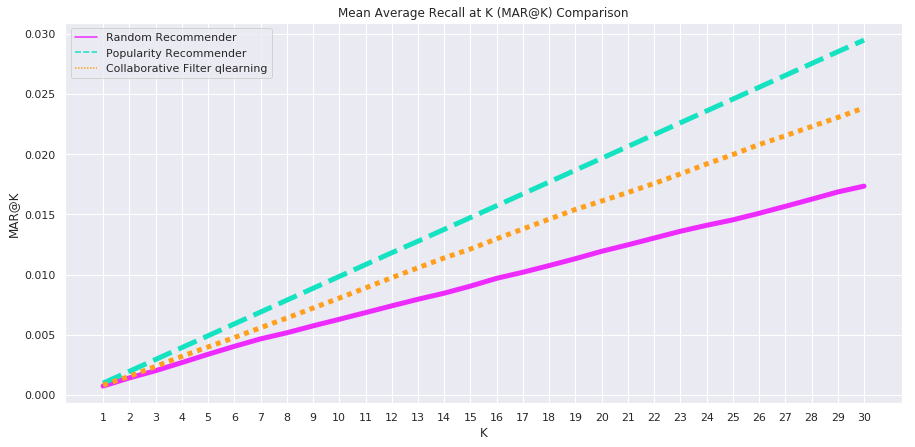

In [27]:
mark_scores = [random_mark, pop_mark, cf_mark]
index = range(1,30+1)
names = ['Random Recommender', 'Popularity Recommender', 'Collaborative Filter qlearning']

fig = plt.figure(figsize=(15, 7))
recmetrics.mark_plot(mark_scores, model_names=names, k_range=index)

In [0]:
catalog = train.item_nbr.unique().tolist()
random_coverage = recmetrics.coverage(random_predictions, catalog)
pop_coverage = recmetrics.coverage(pop_predictions, catalog)
cf_coverage = recmetrics.coverage(cf_predictions, catalog)

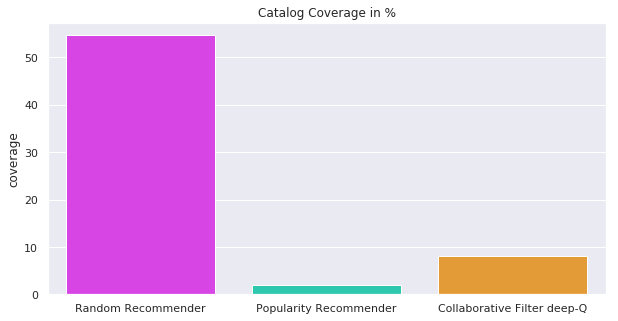

In [29]:
coverage_scores = [random_coverage, pop_coverage, cf_coverage]
model_names = ['Random Recommender', 'Popularity Recommender', 'Collaborative Filter deep-Q']

fig = plt.figure(figsize=(10, 5))
recmetrics.coverage_plot(coverage_scores, model_names)